# Vehicle Detection

In [1]:
import numpy as np
import cv2
import glob
import time
import pickle

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from skimage.feature import hog

from helperfunctions import *

from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [43]:
cars = glob.glob('data/vehicles/*/*.png')
notcars = glob.glob('data/non-vehicles/*/*.png')

print("Vehicles : ",len(cars))
print("Non-Vehicles : ",len(notcars))

Vehicles :  8792
Non-Vehicles :  8968


In [21]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 5  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 5 # HOG cells per block
channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 24    # Number of histogram bins
spatial_feat = False # Spatial features on or off
hist_feat = False # Histogram features on or off
hog_feat = True # HOG features on or off
xy_window_size = (64, 64)
xy_overlap_size = (0.5, 0.5)

y_start_stop = [400, 720] # Min and max in y to search in slide_window()

In [47]:
t=time.time()
car_features = extract_features(cars, color_space=color_space, spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, 
                cell_per_block=cell_per_block, hog_channel=channel, spatial_feat=True, hist_feat=True, hog_feat=True)

with open(r"raw_vehicles_feature.p", "wb") as output_file:
    pickle.dump(car_features, output_file)
print("Vehicles Features has been pickled")    

not_car_features = extract_features(notcars, color_space=color_space, spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, 
                cell_per_block=cell_per_block, hog_channel=channel, spatial_feat=True, hist_feat=True, hog_feat=True)

with open(r"raw_not_vehicles_feature.p", "wb") as output_file:
    pickle.dump(not_car_features, output_file)
print("Not Vehicles Features has been pickled")  

t2 = time.time()
print("Time to extract features : ",round(t2-t, 2))

100%|█████████████████████████████████████████████████████████████████████████████| 8792/8792 [00:50<00:00, 173.76it/s]


Vehicles Features has been pickled


100%|█████████████████████████████████████████████████████████████████████████████| 8968/8968 [01:21<00:00, 109.58it/s]


Not Vehicles Features has been pickled
Time to extract features :  157.04


ValueError: Found input variables with inconsistent numbers of samples: [17760, 9292]

In [1]:
import numpy as np
import cv2
import glob
import time
import pickle

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from skimage.feature import hog

from helperfunctions import *

from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [2]:
with open(r"raw_vehicles_feature.p", "rb") as output_file:
    car_features = pickle.load(output_file)

with open(r"raw_not_vehicles_feature.p", "rb") as output_file:
    not_car_features = pickle.load(output_file)

In [3]:
X = np.vstack((car_features, not_car_features)).astype(np.float64)          
y = np.hstack((np.ones(len(car_features)), np.zeros(len(not_car_features))))

del car_features
del not_car_features

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

print('Feature vector length : ', len(X_train[0]))

Feature vector length :  6840


In [4]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

25.11 Seconds to train SVC...
Test Accuracy of SVC =  0.9856


In [5]:
del X_train
del y_train
del X_test
del y_test

In [6]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 5  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 5 # HOG cells per block
channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 24    # Number of histogram bins
spatial_feat = False # Spatial features on or off
hist_feat = False # Histogram features on or off
hog_feat = True # HOG features on or off
xy_window_size = (64, 64)
xy_overlap_size = (0.5, 0.5)

y_start_stop = [400, 720] # Min and max in y to search in slide_window()

Hot windows:  [((816, 400), (912, 496)), ((864, 400), (960, 496)), ((1056, 400), (1152, 496))]


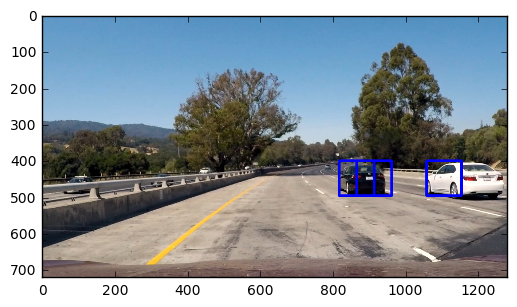

In [14]:
image = mpimg.imread('test_images/test1.jpg')
draw_image = np.copy(image)
image = image.astype(np.float32)/255

# Get list of windows to search at this stage.
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, xy_window=(96, 96), xy_overlap=(0.5, 0.5))

# Return all the windows the classifier has predicted contain car(s) ('positive windows').
hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=channel, spatial_feat=True, hist_feat=True, hog_feat=True)                       

# Draw bounding boxes around the windows that the classifier predicted has cars in them
window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

# Print the coordinates of the corners of the positive windows.
print("Hot windows: ", hot_windows)

# Plot image with bounding boxes drawn.
plt.imshow(window_img)

Hot windows:  []


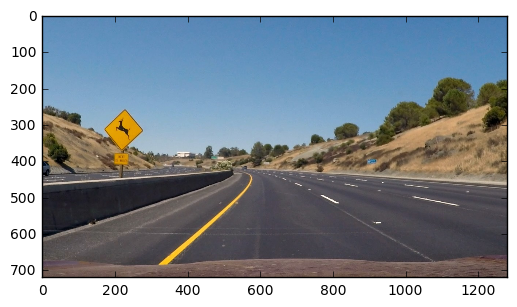

In [16]:
image = mpimg.imread('test_images/test2.jpg')
draw_image = np.copy(image)
image = image.astype(np.float32)/255

# Get list of windows to search at this stage.
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, xy_window=(96, 96), xy_overlap=(0.5, 0.5))

# Return all the windows the classifier has predicted contain car(s) ('positive windows').
hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=channel, spatial_feat=True, hist_feat=True, hog_feat=True)                       

# Draw bounding boxes around the windows that the classifier predicted has cars in them
window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

# Print the coordinates of the corners of the positive windows.
print("Hot windows: ", hot_windows)

# Plot image with bounding boxes drawn.
plt.imshow(window_img)

Hot windows:  [((864, 400), (960, 496))]


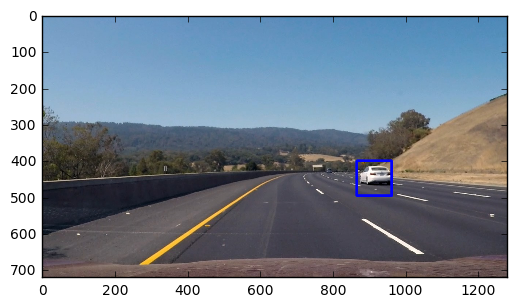

In [17]:
image = mpimg.imread('test_images/test3.jpg')
draw_image = np.copy(image)
image = image.astype(np.float32)/255

# Get list of windows to search at this stage.
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, xy_window=(96, 96), xy_overlap=(0.5, 0.5))

# Return all the windows the classifier has predicted contain car(s) ('positive windows').
hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=channel, spatial_feat=True, hist_feat=True, hog_feat=True)                       

# Draw bounding boxes around the windows that the classifier predicted has cars in them
window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

# Print the coordinates of the corners of the positive windows.
print("Hot windows: ", hot_windows)

# Plot image with bounding boxes drawn.
plt.imshow(window_img)

Hot windows:  [((240, 400), (336, 496)), ((816, 400), (912, 496)), ((864, 400), (960, 496)), ((1104, 400), (1200, 496))]


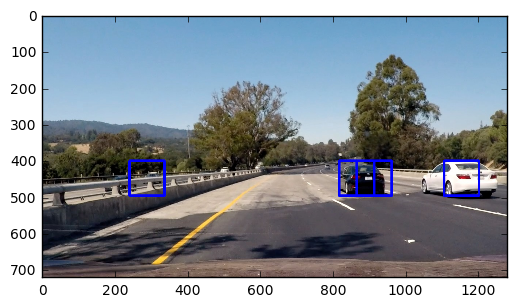

In [18]:
image = mpimg.imread('test_images/test4.jpg')
draw_image = np.copy(image)
image = image.astype(np.float32)/255

# Get list of windows to search at this stage.
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, xy_window=(96, 96), xy_overlap=(0.5, 0.5))

# Return all the windows the classifier has predicted contain car(s) ('positive windows').
hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=channel, spatial_feat=True, hist_feat=True, hog_feat=True)                       

# Draw bounding boxes around the windows that the classifier predicted has cars in them
window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

# Print the coordinates of the corners of the positive windows.
print("Hot windows: ", hot_windows)

# Plot image with bounding boxes drawn.
plt.imshow(window_img)

Hot windows:  [((624, 400), (720, 496)), ((720, 400), (816, 496)), ((768, 400), (864, 496)), ((816, 400), (912, 496)), ((864, 400), (960, 496)), ((1104, 400), (1200, 496)), ((576, 448), (672, 544))]


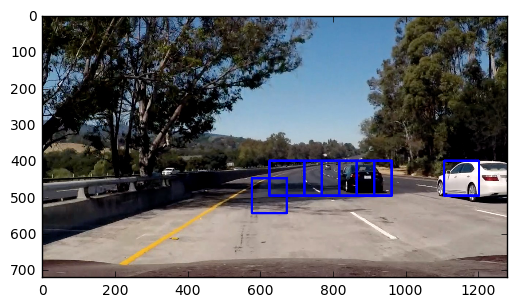

In [19]:
image = mpimg.imread('test_images/test5.jpg')
draw_image = np.copy(image)
image = image.astype(np.float32)/255

# Get list of windows to search at this stage.
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, xy_window=(96, 96), xy_overlap=(0.5, 0.5))

# Return all the windows the classifier has predicted contain car(s) ('positive windows').
hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=channel, spatial_feat=True, hist_feat=True, hog_feat=True)                       

# Draw bounding boxes around the windows that the classifier predicted has cars in them
window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

# Print the coordinates of the corners of the positive windows.
print("Hot windows: ", hot_windows)

# Plot image with bounding boxes drawn.
plt.imshow(window_img)

Hot windows:  [((816, 400), (912, 496)), ((864, 400), (960, 496)), ((1008, 400), (1104, 496)), ((1056, 400), (1152, 496))]


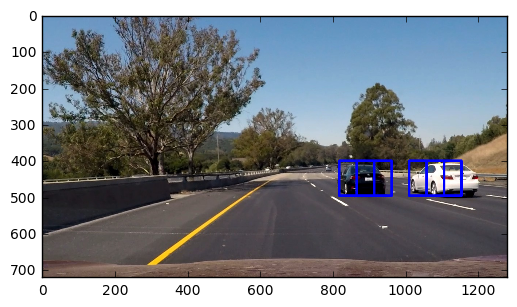

In [20]:
image = mpimg.imread('test_images/test6.jpg')
draw_image = np.copy(image)
image = image.astype(np.float32)/255

# Get list of windows to search at this stage.
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, xy_window=(96, 96), xy_overlap=(0.5, 0.5))

# Return all the windows the classifier has predicted contain car(s) ('positive windows').
hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=channel, spatial_feat=True, hist_feat=True, hog_feat=True)                       

# Draw bounding boxes around the windows that the classifier predicted has cars in them
window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

# Print the coordinates of the corners of the positive windows.
print("Hot windows: ", hot_windows)

# Plot image with bounding boxes drawn.
plt.imshow(window_img)

In [ ]:
def add_bboxes(input_image, windows, classifier, scaler, draw=True, bboxes_only=False):
    global bboxes_list
    
    # Normalise image
    # input_image = normalise(input_image)
    
    hot_windows = search_windows(input_image, windows, classifier, scaler, color_space=color_space,
                        spatial_size=spatial_size, hist_bins=hist_bins,
                        orient=orient, pix_per_cell=pix_per_cell,
                        cell_per_block=cell_per_block,
                        hog_channel=channel, spatial_feat=spatial_feat,
                        hist_feat=hist_feat, hog_feat=hog_feat)
    print("Hot windows: ", hot_windows)
    bboxes_list.append(hot_windows)
    if draw == True:
        draw_image = np.copy(input_image)
        window_img = draw_boxes(input_image, hot_windows, color=(0, 0, 255), thick=6)
        return window_img
    
def add_bboxes_to_list(image):
    return add_bboxes(image, windows, svc, X_scaler)

In [21]:
def add_heat(heatmap, box_list):
    # Iterate through list of bboxes
    for box in box_list:
        # Add += 1 for all pixels inside each bbox
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def draw_filtered_bboxes(image, all_bboxes, recent_frames_used=20, threshold=5): 
    
    add_bboxes(image, windows, svc, X_scaler, draw=False) 
    if len(all_bboxes) < recent_frames_used + 1:
        recent_frames_used = len(all_bboxes) - 1    
    frame_heatmap = np.zeros_like(image[:,:,0])
    for boxlist in all_bboxes[-recent_frames_used:]:
        frame_heatmap = add_heat(frame_heatmap, boxlist)
    frame_heatmap = apply_threshold(frame_heatmap, threshold)
    labels = label(frame_heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    plt.imshow(draw_img)
    
    return draw_img

def pipeline(image):
    global bboxes_list    
    
    return draw_filtered_bboxes(image, bboxes_list)

In [22]:
bboxes_list = []
video = VideoFileClip("project_video.mp4")
project_clip = video.fl_image(pipeline) 
video_output = "output.mp4"
project_clip.write_videofile(video_output, audio=False)

OSError: [WinError 6] The handle is invalid

In [25]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))